# HW2 Deep Learning

## Tina Khezr-Esameilzadeh
### 96101595

In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from sklearn.metrics import roc_auc_score, accuracy_score

In [2]:
# download dataset
(data, label), (x_test, y_test) = mnist.load_data()

# 80 percent train data and 20 percent test data
percent = 0.8
x_train = data[:int(percent*data.shape[0])]
y_train = label[:int(percent*label.shape[0])]

x_test = data[int(percent*data.shape[0]):]
y_test = label[int(percent*label.shape[0]):]

# Flattening The Data
x_train = x_train.reshape([x_train.shape[0], -1])
x_test = x_test.reshape([x_test.shape[0], -1])

# Reshaping The Data
x_train = x_train.reshape(-1, 784).astype('float32')
x_test = x_test.reshape(-1, 784).astype('float32')

# Normalizing The Data
gray_scale = 255
x_train /= gray_scale
x_test /= gray_scale


print(x_train.shape)
print(x_test.shape)

(48000, 784)
(12000, 784)


In [3]:
# Changing To One Hot Encoding 
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
print(y_train.shape)
print(y_test.shape)

(48000, 10)
(12000, 10)


## Implementing MLP without Dropout

In [4]:
s = tf.InteractiveSession()

# Features Of The Model
nClasses = y_train.shape[1]
nFeatures = x_train.shape[1]
nLayers_1 = 60

starter_learning_rate = 0.001
regularizer_rate = 0.1

# Input Layer
X = tf.placeholder('float32',shape =(None,nFeatures),name="X")
Y = tf.placeholder('float32',shape = (None,nClasses),name='Y')

# Weights initialized by random normal function with std_dev = 1/sqrt(number of input features)
weights_1 = tf.Variable(tf.random_normal([nFeatures,nLayers_1], stddev=(1/tf.sqrt(float(nFeatures)))))
bias_1 = tf.Variable(tf.random_normal([nLayers_1]))

weights_2 = tf.Variable(tf.random_normal([nLayers_1,nClasses], stddev=(1/tf.sqrt(float(nLayers_1)))))
bias_2 = tf.Variable(tf.random_normal([nClasses]))

# Initializing weigths and biases
hidden_output_1 = tf.nn.relu(tf.matmul(X,weights_1)+bias_1)
predicted_y = tf.sigmoid(tf.matmul(hidden_output_1,weights_2) + bias_2)

# Loss Function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predicted_y,labels=Y)) \
        + regularizer_rate*(tf.reduce_sum(tf.square(bias_1)) + tf.reduce_sum(tf.square(bias_2)))

# Learning Rate
learning_rate = tf.train.exponential_decay(starter_learning_rate, 0, 5, 0.85, staircase=True)
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss,var_list=[weights_1,weights_2,
                                                                         bias_1,bias_2])

# Metrics definition
correct_prediction = tf.equal(tf.argmax(y_train,1), tf.argmax(predicted_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [167]:
# Training parameters
batch_size = 128
epochs=20
training_accuracy = []
training_loss = []
testing_accuracy = []

s.run(tf.global_variables_initializer())

for epoch in range(epochs):    
    arr = np.arange(x_train.shape[0])
    np.random.shuffle(arr)
    
    for index in range(0,x_train.shape[0],batch_size):
        s.run(optimizer, {X: x_train[arr[index:index+batch_size]],
                          Y: y_train[arr[index:index+batch_size]],})
        
    training_accuracy.append(s.run(accuracy, feed_dict= {X:x_train, 
                                                         Y: y_train}))
    training_loss.append(s.run(loss, {X: x_train, 
                                      Y: y_train}))
    
    # Evaluation of model
    testing_accuracy.append(accuracy_score(y_test.argmax(1), 
                            s.run(predicted_y, {X: x_test}).argmax(1)))
    print("Epoch:{0}, Train loss: {1:.2f} Train acc: {2:.3f}, Test acc:{3:.3f}".format(epoch,
                                                                    training_loss[epoch],
                                                                    training_accuracy[epoch],
                                                                   testing_accuracy[epoch]))

Epoch:0, Train loss: 6.04 Train acc: 0.896, Test acc:0.900
Epoch:1, Train loss: 4.21 Train acc: 0.915, Test acc:0.920
Epoch:2, Train loss: 3.14 Train acc: 0.929, Test acc:0.931
Epoch:3, Train loss: 2.50 Train acc: 0.939, Test acc:0.940
Epoch:4, Train loss: 2.11 Train acc: 0.946, Test acc:0.945
Epoch:5, Train loss: 1.88 Train acc: 0.951, Test acc:0.950
Epoch:6, Train loss: 1.74 Train acc: 0.955, Test acc:0.952
Epoch:7, Train loss: 1.65 Train acc: 0.958, Test acc:0.955
Epoch:8, Train loss: 1.59 Train acc: 0.961, Test acc:0.957
Epoch:9, Train loss: 1.55 Train acc: 0.963, Test acc:0.958
Epoch:10, Train loss: 1.52 Train acc: 0.964, Test acc:0.958
Epoch:11, Train loss: 1.51 Train acc: 0.967, Test acc:0.961
Epoch:12, Train loss: 1.50 Train acc: 0.968, Test acc:0.961
Epoch:13, Train loss: 1.49 Train acc: 0.969, Test acc:0.961
Epoch:14, Train loss: 1.49 Train acc: 0.971, Test acc:0.963
Epoch:15, Train loss: 1.49 Train acc: 0.972, Test acc:0.963
Epoch:16, Train loss: 1.49 Train acc: 0.973, Test 

## Implementing MLP with Dropout Of Tensorflow P = 0.2

In [53]:
s.close()
s = tf.InteractiveSession()

nClasses = y_train.shape[1]
nFeatures = x_train.shape[1]
nLayers_1 = 60

starter_learning_rate = 0.001
regularizer_rate = 0.1

# Input Layer
X = tf.placeholder('float32',shape =(None,nFeatures),name="X")
Y = tf.placeholder('float32',shape = (None,nClasses),name='Y')
Prob = tf.placeholder(tf.float32)

# Weights initialized by random normal function with std_dev = 1/sqrt(number of input features)
weights_1 = tf.Variable(tf.random_normal([nFeatures,nLayers_1], stddev=(1/tf.sqrt(float(nFeatures)))))
bias_1 = tf.Variable(tf.random_normal([nLayers_1]))

weights_2 = tf.Variable(tf.random_normal([nLayers_1,nClasses], stddev=(1/tf.sqrt(float(nLayers_1)))))
bias_2 = tf.Variable(tf.random_normal([nClasses]))

# Initializing weigths and biases
hidden_output_1 = tf.nn.relu(tf.matmul(X,weights_1)+bias_1)
hidden_output_1_dropout = tf.nn.dropout(hidden_output_1, rate = 1- Prob)
predicted_y = tf.sigmoid(tf.matmul(hidden_output_1_dropout,weights_2) + bias_2)

# Loss Function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predicted_y,labels=Y)) \
        + regularizer_rate*(tf.reduce_sum(tf.square(bias_1)) + tf.reduce_sum(tf.square(bias_2)))

# Learning Rate
learning_rate = tf.train.exponential_decay(starter_learning_rate, 0, 5, 0.85, staircase=True)
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss,var_list=[weights_1,weights_2,
                                                                         bias_1,bias_2])

# Metrics definition
correct_prediction = tf.equal(tf.argmax(y_train,1), tf.argmax(predicted_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [56]:
# Training parameters
batch_size = 128
epochs=20
DropoutProb = 0.2
training_accuracy = []
training_loss = []
testing_accuracy = []

s.run(tf.global_variables_initializer())

for epoch in range(epochs):    
    arr = np.arange(x_train.shape[0])
    np.random.shuffle(arr)
    
    for index in range(0,x_train.shape[0],batch_size):
        s.run(optimizer, {X: x_train[arr[index:index+batch_size]],
                          Y: y_train[arr[index:index+batch_size]],
                         Prob: DropoutProb })
        
    training_accuracy.append(s.run(accuracy, feed_dict= {X:x_train, 
                                                         Y: y_train,
                                                        Prob: 1}))
    training_loss.append(s.run(loss, {X: x_train, 
                                      Y: y_train,
                                     Prob: 1}))
    
    ## Evaluation of model
    testing_accuracy.append(accuracy_score(y_test.argmax(1), 
                            s.run(predicted_y, {X: x_test, Prob: 1}).argmax(1)))
    print("Epoch:{0}, Train loss: {1:.2f} Train acc: {2:.3f}, Test acc:{3:.3f}".format(epoch,
                                                                    training_loss[epoch],
                                                                    training_accuracy[epoch],
                                                                   testing_accuracy[epoch]))

Epoch:0, Train loss: 4.89 Train acc: 0.861, Test acc:0.876
Epoch:1, Train loss: 3.39 Train acc: 0.888, Test acc:0.900
Epoch:2, Train loss: 2.59 Train acc: 0.894, Test acc:0.906
Epoch:3, Train loss: 2.15 Train acc: 0.901, Test acc:0.909
Epoch:4, Train loss: 1.90 Train acc: 0.903, Test acc:0.910
Epoch:5, Train loss: 1.76 Train acc: 0.907, Test acc:0.912
Epoch:6, Train loss: 1.67 Train acc: 0.910, Test acc:0.915
Epoch:7, Train loss: 1.62 Train acc: 0.912, Test acc:0.917
Epoch:8, Train loss: 1.59 Train acc: 0.913, Test acc:0.919
Epoch:9, Train loss: 1.57 Train acc: 0.914, Test acc:0.919
Epoch:10, Train loss: 1.56 Train acc: 0.917, Test acc:0.921
Epoch:11, Train loss: 1.55 Train acc: 0.918, Test acc:0.921
Epoch:12, Train loss: 1.55 Train acc: 0.918, Test acc:0.922
Epoch:13, Train loss: 1.55 Train acc: 0.919, Test acc:0.923
Epoch:14, Train loss: 1.55 Train acc: 0.920, Test acc:0.923
Epoch:15, Train loss: 1.55 Train acc: 0.921, Test acc:0.924
Epoch:16, Train loss: 1.55 Train acc: 0.922, Test 

## Implementing MLP with Dropout Of Tensorflow P=0.6

In [63]:
s.close()
s = tf.InteractiveSession()

nClasses = y_train.shape[1]
nFeatures = x_train.shape[1]
nLayers_1 = 60

starter_learning_rate = 0.001
regularizer_rate = 0.1

# Input Layer
X = tf.placeholder('float32',shape =(None,nFeatures),name="X")
Y = tf.placeholder('float32',shape = (None,nClasses),name='Y')
Prob = tf.placeholder(tf.float32)

# Weights initialized by random normal function with std_dev = 1/sqrt(number of input features)
weights_1 = tf.Variable(tf.random_normal([nFeatures,nLayers_1], stddev=(1/tf.sqrt(float(nFeatures)))))
bias_1 = tf.Variable(tf.random_normal([nLayers_1]))

weights_2 = tf.Variable(tf.random_normal([nLayers_1,nClasses], stddev=(1/tf.sqrt(float(nLayers_1)))))
bias_2 = tf.Variable(tf.random_normal([nClasses]))

# Initializing weigths and biases
hidden_output_1 = tf.nn.relu(tf.matmul(X,weights_1)+bias_1)
hidden_output_1_dropout = tf.nn.dropout(hidden_output_1, rate = 1- Prob)
predicted_y = tf.sigmoid(tf.matmul(hidden_output_1_dropout,weights_2) + bias_2)

# Loss Function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predicted_y,labels=Y)) \
        + regularizer_rate*(tf.reduce_sum(tf.square(bias_1)) + tf.reduce_sum(tf.square(bias_2)))

# Learning Rate
learning_rate = tf.train.exponential_decay(starter_learning_rate, 0, 5, 0.85, staircase=True)
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss,var_list=[weights_1,weights_2,
                                                                         bias_1,bias_2])

# Metrics definition
correct_prediction = tf.equal(tf.argmax(y_train,1), tf.argmax(predicted_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

C:\Python\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\client\session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [59]:
# Training parameters
batch_size = 128
epochs=20
DropoutProb = 0.6
training_accuracy = []
training_loss = []
testing_accuracy = []

s.run(tf.global_variables_initializer())

for epoch in range(epochs):    
    arr = np.arange(x_train.shape[0])
    np.random.shuffle(arr)
    
    for index in range(0,x_train.shape[0],batch_size):
        s.run(optimizer, {X: x_train[arr[index:index+batch_size]],
                          Y: y_train[arr[index:index+batch_size]],
                         Prob: DropoutProb })
        
    training_accuracy.append(s.run(accuracy, feed_dict= {X:x_train, 
                                                         Y: y_train,
                                                        Prob: 1}))
    training_loss.append(s.run(loss, {X: x_train, 
                                      Y: y_train,
                                     Prob: 1}))
    
    ## Evaluation of model
    testing_accuracy.append(accuracy_score(y_test.argmax(1), 
                            s.run(predicted_y, {X: x_test, Prob: 1}).argmax(1)))
    print("Epoch:{0}, Train loss: {1:.2f} Train acc: {2:.3f}, Test acc:{3:.3f}".format(epoch,
                                                                    training_loss[epoch],
                                                                    training_accuracy[epoch],
                                                                   testing_accuracy[epoch]))

Epoch:0, Train loss: 5.37 Train acc: 0.882, Test acc:0.893
Epoch:1, Train loss: 3.67 Train acc: 0.908, Test acc:0.913
Epoch:2, Train loss: 2.72 Train acc: 0.921, Test acc:0.926
Epoch:3, Train loss: 2.19 Train acc: 0.928, Test acc:0.931
Epoch:4, Train loss: 1.88 Train acc: 0.933, Test acc:0.935
Epoch:5, Train loss: 1.71 Train acc: 0.937, Test acc:0.938
Epoch:6, Train loss: 1.61 Train acc: 0.940, Test acc:0.940
Epoch:7, Train loss: 1.56 Train acc: 0.943, Test acc:0.942
Epoch:8, Train loss: 1.53 Train acc: 0.945, Test acc:0.944
Epoch:9, Train loss: 1.52 Train acc: 0.947, Test acc:0.945
Epoch:10, Train loss: 1.51 Train acc: 0.948, Test acc:0.947
Epoch:11, Train loss: 1.51 Train acc: 0.950, Test acc:0.949
Epoch:12, Train loss: 1.51 Train acc: 0.951, Test acc:0.949
Epoch:13, Train loss: 1.51 Train acc: 0.952, Test acc:0.951
Epoch:14, Train loss: 1.50 Train acc: 0.954, Test acc:0.951
Epoch:15, Train loss: 1.50 Train acc: 0.955, Test acc:0.952
Epoch:16, Train loss: 1.50 Train acc: 0.956, Test 

## Implementing Dropout Layer Manually

In [159]:
s.close()
s = tf.InteractiveSession()

nClasses = y_train.shape[1]
nFeatures = x_train.shape[1]
nLayers_1 = 60

starter_learning_rate = 0.001
regularizer_rate = 0.1

# Input Layer
X = tf.placeholder('float32',shape =(None,nFeatures),name="X")
Y = tf.placeholder('float32',shape = (None,nClasses),name='Y')
Prob = 0.6

# Weights initialized by random normal function with std_dev = 1/sqrt(number of input features)
weights_1 = tf.Variable(tf.random_normal([nFeatures,nLayers_1], stddev=(1/tf.sqrt(float(nFeatures)))))
bias_1 = tf.Variable(tf.random_normal([nLayers_1]))

# Dropout Weights Initialization
weights_dropout = np.zeros((nLayers_1, nLayers_1))
for i in range(nLayers_1): 
    random_result = np.random.binomial(1, Prob)
    if random_result == 1:
        weights_dropout[i,i] = 1

weights_dropout = weights_dropout.astype('float32')

weights_2 = tf.Variable(tf.random_normal([nLayers_1,nClasses], stddev=(1/tf.sqrt(float(nLayers_1)))))
bias_2 = tf.Variable(tf.random_normal([nClasses]))

# Initializing weigths and biases
hidden_output_1 = tf.nn.relu(tf.matmul(X,weights_1)+bias_1)
hidden_output_1_dropout = tf.nn.relu(tf.matmul(hidden_output_1,weights_dropout))

predicted_y = tf.sigmoid(tf.matmul(hidden_output_1_dropout,weights_2) + bias_2)

# Loss Function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predicted_y,labels=Y)) \
        + regularizer_rate*(tf.reduce_sum(tf.square(bias_1)) + tf.reduce_sum(tf.square(bias_2)))

# Learning Rate
learning_rate = tf.train.exponential_decay(starter_learning_rate, 0, 5, 0.85, staircase=True)
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss,var_list=[weights_1,weights_2,
                                                                         bias_1,bias_2])

# Metrics definition
correct_prediction = tf.equal(tf.argmax(y_train,1), tf.argmax(predicted_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

C:\Python\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\client\session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [160]:
# Training parameters
batch_size = 128
epochs=20
DropoutProb = 0.6
training_accuracy = []
training_loss = []
testing_accuracy = []

s.run(tf.global_variables_initializer())

for epoch in range(epochs):    
    arr = np.arange(x_train.shape[0])
    np.random.shuffle(arr)
    
    for index in range(0,x_train.shape[0],batch_size):
        s.run(optimizer, {X: x_train[arr[index:index+batch_size]],
                          Y: y_train[arr[index:index+batch_size]]})
        
    training_accuracy.append(s.run(accuracy, feed_dict= {X:x_train, 
                                                         Y: y_train }))
    training_loss.append(s.run(loss, {X: x_train, 
                                      Y: y_train }))
    
    ## Evaluation of model
    testing_accuracy.append(accuracy_score(y_test.argmax(1), 
                            s.run(predicted_y, {X: x_test}).argmax(1)))
    print("Epoch:{0}, Train loss: {1:.2f} Train acc: {2:.3f}, Test acc:{3:.3f}".format(epoch,
                                                                    training_loss[epoch],
                                                                    training_accuracy[epoch],
                                                                   testing_accuracy[epoch]))

Epoch:0, Train loss: 6.32 Train acc: 0.888, Test acc:0.896
Epoch:1, Train loss: 4.26 Train acc: 0.906, Test acc:0.915
Epoch:2, Train loss: 3.06 Train acc: 0.921, Test acc:0.926
Epoch:3, Train loss: 2.35 Train acc: 0.930, Test acc:0.934
Epoch:4, Train loss: 1.96 Train acc: 0.937, Test acc:0.940
Epoch:5, Train loss: 1.74 Train acc: 0.942, Test acc:0.944
Epoch:6, Train loss: 1.63 Train acc: 0.945, Test acc:0.946
Epoch:7, Train loss: 1.57 Train acc: 0.949, Test acc:0.948
Epoch:8, Train loss: 1.53 Train acc: 0.951, Test acc:0.949
Epoch:9, Train loss: 1.52 Train acc: 0.954, Test acc:0.952
Epoch:10, Train loss: 1.51 Train acc: 0.955, Test acc:0.955
Epoch:11, Train loss: 1.50 Train acc: 0.957, Test acc:0.955
Epoch:12, Train loss: 1.50 Train acc: 0.959, Test acc:0.955
Epoch:13, Train loss: 1.50 Train acc: 0.960, Test acc:0.956
Epoch:14, Train loss: 1.50 Train acc: 0.961, Test acc:0.957
Epoch:15, Train loss: 1.50 Train acc: 0.962, Test acc:0.957
Epoch:16, Train loss: 1.49 Train acc: 0.963, Test 

## Implementing CNN Using Batch Normalization

In [18]:
import tensorflow as tf

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)


# Training Parameters
starter_learning_rate = 0.001
learning_rate = tf.train.exponential_decay(starter_learning_rate, 0, 5, 0.85, staircase=True)
epochs = 20
batch_size = 128
display_step = 10

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)


# Create some wrappers for simplicity
def conv2d(x, W, b, padding, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'],strides=1,padding='SAME')
    print(conv1.shape)
    
    mean1, var1 = tf.nn.moments(conv1, [0, 1, 2])
    conv1 = tf.nn.batch_normalization(conv1, mean1, var1, 0, 1, 0.0001)
    
    
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'],strides=1,padding='VALID')
    
    mean2, var2 = tf.nn.moments(conv2, [0, 1, 2])
    conv2 = tf.nn.batch_normalization(conv2, mean2, var2, 0, 1, 0.0001)
    
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'],strides=1,padding='SAME')
    
    mean3, var3 = tf.nn.moments(conv3, [0, 1, 2])
    conv3 = tf.nn.batch_normalization(conv3, mean3, var3, 0, 1, 0.0001)
    

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['out'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    out = tf.nn.dropout(fc1, dropout)

    
    
    return out

# Store layers weight & bias
weights = {
    # 3x3 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([3, 3, 1, 32])),
    # 7x7 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([7, 7, 32, 64])),
    # 3x3 conv, 64 input, 1 outputs
    'wc3': tf.Variable(tf.random_normal([3, 3, 64, 1])),
    # 64 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([64, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bc3': tf.Variable(tf.random_normal([1])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

# Construct model
logits = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)


# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for epoch in range(epochs):
        arr = np.arange(x_train.shape[0])
        np.random.shuffle(arr)
        for index in range(0,x_train.shape[0],batch_size):
            batch_x = x_train[arr[index:index+batch_size]]
            batch_y = y_train[arr[index:index+batch_size]]
        
            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: 0.8})
            
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y,
                                                                 keep_prob: 1.0})
        print("Epoch " + str(epoch) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc),"Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: x_test,
                                      Y: y_test,
                                      keep_prob: 1.0}))
        
        
    print("Optimization Finished!")

    # Calculate accuracy for 256 MNIST test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: x_test,
                                      Y: y_test,
                                      keep_prob: 1.0}))
    
    

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
(?, 28, 28, 32)
(?, 14, 14, 32)
Epoch 0, Minibatch Loss= 11.2773, Training Accuracy= 0.883 Testing Accuracy: 0.8295
Epoch 1, Minibatch Loss= 5.6592, Training Accuracy= 0.797 Testing Accuracy: 0.76883334
Epoch 2, Minibatch Loss= 3.7319, Training Accuracy= 0.641 Testing Accuracy: 0.62
Epoch 3, Minibatch Loss= 1.3827, Training Accuracy= 0.562 Testing Accuracy: 0.6185
Epoch 4, Minibatch Loss= 1.5331, Training Accuracy= 0.680 Testing Accuracy: 0.67191666
Epoch 5, Minibatch Loss= 1.1601, Training Accuracy= 0.727 Testing Accuracy: 0.71608335
Epoch 6, Minibatch Loss= 1.2438, Training Accuracy= 0.719 Testing Accuracy: 0.72908336
Epoch 7, Minibatch Loss= 1.0984, Training Accuracy= 0.742 Testing Accuracy: 0.7445
Epoch 8, Minibatch Loss= 0.6000, Training Accuracy= 0.836 Testing Accuracy: 0.77641666
Epoch 9, Min

## Implementing Batch Normalization Manually

In [11]:
import tensorflow as tf

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)


# Training Parameters
starter_learning_rate = 0.001
learning_rate = tf.train.exponential_decay(starter_learning_rate, 0, 5, 0.85, staircase=True)
epochs = 20
batch_size = 128
display_step = 10

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)


# Create some wrappers for simplicity
def conv2d(x, W, b, padding, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'],strides=1,padding='SAME')
    print(conv1.shape)
    
    epsilon = 0.0001
    mean1, var1 = tf.nn.moments(conv1, [0])
    conv1 = (conv1 - mean1) / tf.sqrt(var1 + epsilon)

    # Create two new parameters, scale and beta (shift)
    scale1 = tf.Variable(tf.ones([biases['bc1'].shape[0]]))
    beta1 = tf.Variable(tf.zeros([biases['bc1'].shape[0]]))
    conv1 = scale1*conv1 + beta1
    
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'],strides=1,padding='VALID')
    
    mean2, var2 = tf.nn.moments(conv2, [0])
    conv2 = (conv2 - mean2) / tf.sqrt(var2 + epsilon)

    # Create two new parameters, scale and beta (shift)
    scale2 = tf.Variable(tf.ones([biases['bc2'].shape[0]]))
    beta2 = tf.Variable(tf.zeros([biases['bc2'].shape[0]]))
    conv2 = scale2*conv2 + beta2
    
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'],strides=1,padding='SAME')    
    mean3, var3 = tf.nn.moments(conv3, [0])
    conv3 = (conv3 - mean3) / tf.sqrt(var3 + epsilon)

    # Create two new parameters, scale and beta (shift)
    scale3 = tf.Variable(tf.ones([biases['bc3'].shape[0]]))
    beta3 = tf.Variable(tf.zeros([biases['bc3'].shape[0]]))
    conv3 = scale3*conv3 + beta3
    

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['out'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    out = tf.nn.dropout(fc1, dropout)

    
    
    return out

# Store layers weight & bias
weights = {
    # 3x3 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([3, 3, 1, 32])),
    # 7x7 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([7, 7, 32, 64])),
    # 3x3 conv, 64 input, 1 outputs
    'wc3': tf.Variable(tf.random_normal([3, 3, 64, 1])),
    # 64 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([64, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bc3': tf.Variable(tf.random_normal([1])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

# Construct model
logits = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)


# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for epoch in range(epochs):
        arr = np.arange(x_train.shape[0])
        np.random.shuffle(arr)
        for index in range(0,x_train.shape[0],batch_size):
            batch_x = x_train[arr[index:index+batch_size]]
            batch_y = y_train[arr[index:index+batch_size]]
        
            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: 0.8})
            
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y,
                                                                 keep_prob: 1.0})
        print("Epoch " + str(epoch) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc),"Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: x_test,
                                      Y: y_test,
                                      keep_prob: 1.0}))
        
        
    print("Optimization Finished!")

    # Calculate accuracy for 256 MNIST test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: x_test,
                                      Y: y_test,
                                      keep_prob: 1.0}))
    
    

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
(?, 28, 28, 32)
(?, 14, 14, 32)
(?, 8, 8, 64)
Epoch 1, Minibatch Loss= 476.0650, Training Accuracy= 0.070 Testing Accuracy: 0.07421875
Epoch 10, Minibatch Loss= 458.2487, Training Accuracy= 0.148 Testing Accuracy: 0.16796875
Epoch 20, Minibatch Loss= 367.9552, Training Accuracy= 0.266 Testing Accuracy: 0.28125
Epoch 30, Minibatch Loss= 229.3100, Training Accuracy= 0.391 Testing Accuracy: 0.37890625
Epoch 40, Minibatch Loss= 173.8680, Training Accuracy= 0.477 Testing Accuracy: 0.46484375
Epoch 50, Minibatch Loss= 119.4776, Training Accuracy= 0.555 Testing Accuracy: 0.515625
Epoch 60, Minibatch Loss= 122.1234, Training Accuracy= 0.555 Testing Accuracy: 0.5859375
Epoch 70, Minibatch Loss= 110.9895, Training Accuracy= 0.594 Testing Accuracy: 0.61328125
Epoch 80, Minibatch Loss= 64.1467, Training Accurac

## Loading Pretrained Model Of VGG16

In [88]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
553467904/553467096 [==============================] - 2882s 5us/step


## Plotting Filters Of The Second Layer Of VGG16

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

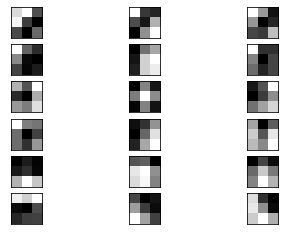

In [117]:
from matplotlib import pyplot as plt
print(model.summary())

filters, biases = model.layers[2].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
        
# show the figure
plt.show()

## Predicting Examples of ImageNet

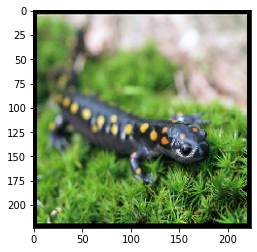

In [128]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions

# load an image from file
image = load_img('spotted_salamander.jpg', target_size=(224, 224))
plt.imshow(image)


## Plotting The Outputs Of Different Layers

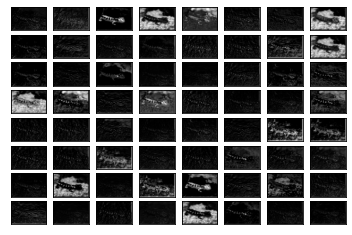

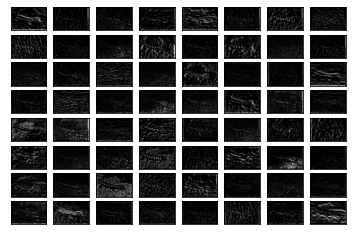

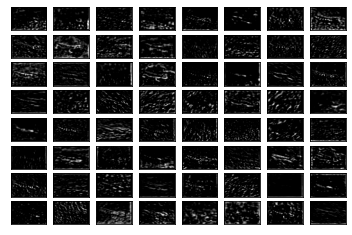

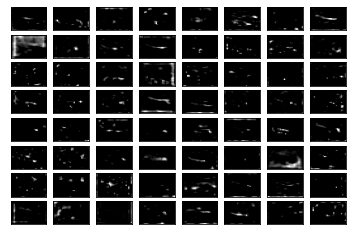

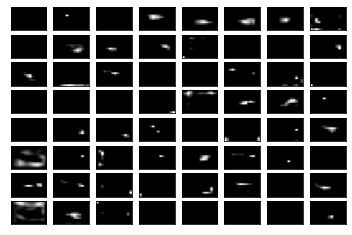

In [126]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
img = load_img('spotted_salamander.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
    # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray',aspect='auto')
            ix += 1
    # show the figure
    pyplot.show()

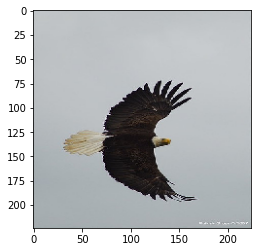

In [131]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions

# load an image from file
image = load_img('bald_eagle.jpg', target_size=(224, 224))
plt.imshow(image)


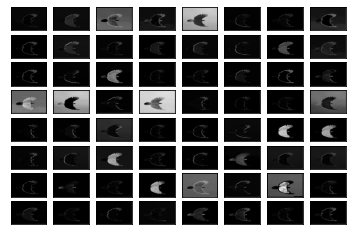

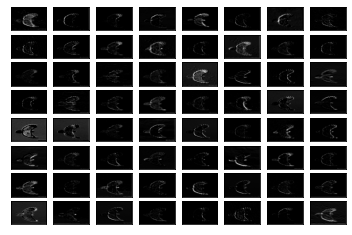

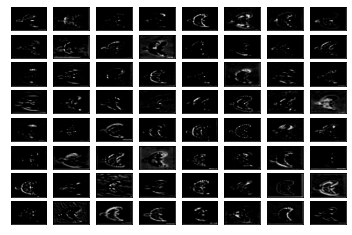

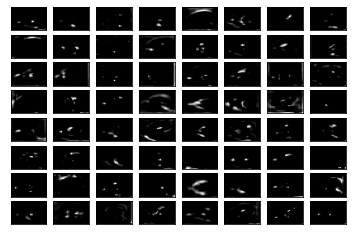

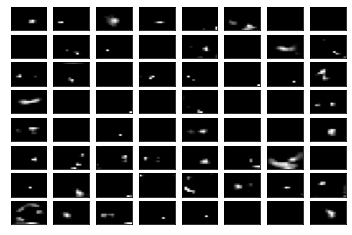

In [132]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
img = load_img('bald_eagle.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
    # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray',aspect='auto')
            ix += 1
    # show the figure
    pyplot.show()

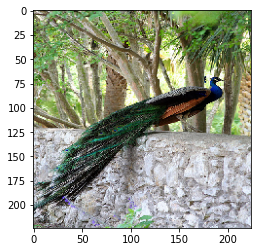

In [172]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions

# load an image from file
image = load_img('peacock.jpg', target_size=(224, 224))
plt.imshow(image)


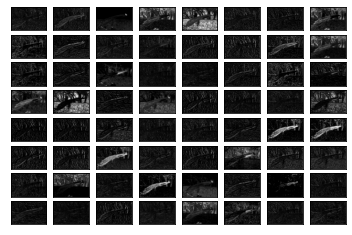

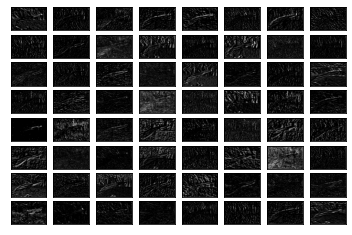

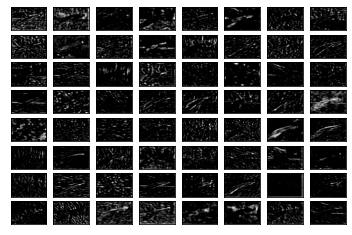

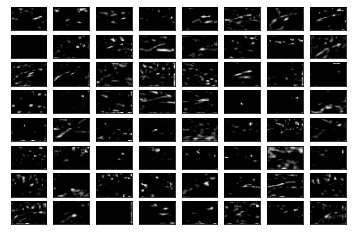

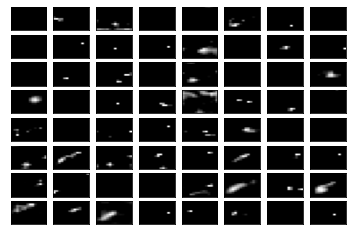

In [173]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
img = load_img('peacock.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
    # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray',aspect='auto')
            ix += 1
    # show the figure
    pyplot.show()

## Last Part

In [ ]:
layer_names = []
for layer in model.layers[1:3]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')